## Introduction

Let's try functional linear regression using basis expansions with a roughness penalty chosen by cross-validation.

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle

import skfda
from skfda.misc.operators import LinearDifferentialOperator
from skfda.misc.regularization import L2Regularization
from skfda.ml.regression import LinearRegression as FLinearRegression
from skfda.representation.basis import BSplineBasis
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

from tecatorfda.ols_models import (
    plot_and_save_ols_ridge_cv_boxplots,
)
from tecatorfda.data import load_tecator_fat

## Load the fetched/processed data

In [2]:
tecator_df, fat_df, wavelength_grid, wavelength_unit = load_tecator_fat()

fat = fat_df.values.flatten()

N = tecator_df.shape[0]
n = tecator_df.shape[1]

print(f"Number of samples: N={N}")
print(f"Number of observations per sample: n={n}")

Number of samples: N=215
Number of observations per sample: n=100


## Fetch the data in FDataGrid form

In [3]:
tecator_fdatagrid, y_fdatagrid = skfda.datasets.fetch_tecator(return_X_y=True, as_frame=False)

# From my book replication notebook

## Visualize the absorbance data

We plot each absorbance curve and color based on fat content.

In [4]:
norm = matplotlib.colors.Normalize(
    vmin=fat.min(),
    vmax=fat.max()
)

# Each climate is assigned a color. Defaults to grey.
colormap = matplotlib.colormaps['seismic']
curve_colors = colormap(norm(fat))

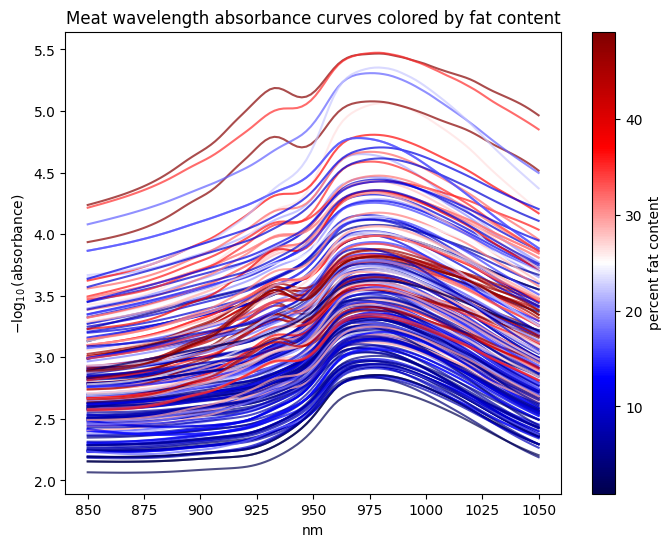

In [5]:
from matplotlib.cm import ScalarMappable

# --- Plot each temperature curve individually ---
plt.figure(figsize=(8, 6))
ax = plt.gca()

for i in range(tecator_df.shape[0]):
    plt.plot(
        wavelength_grid,
        tecator_df.iloc[i],
        color=curve_colors[i],
        alpha=0.7
    )

plt.xlabel(wavelength_unit)
plt.ylabel(r"$-\log_{10}(\text{absorbance})$")
plt.title("Meat wavelength absorbance curves colored by fat content")

# --- Colorbar ---
sm = ScalarMappable(norm=norm, cmap=colormap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("percent fat content")

plt.show()

## Visualize fat content distribution

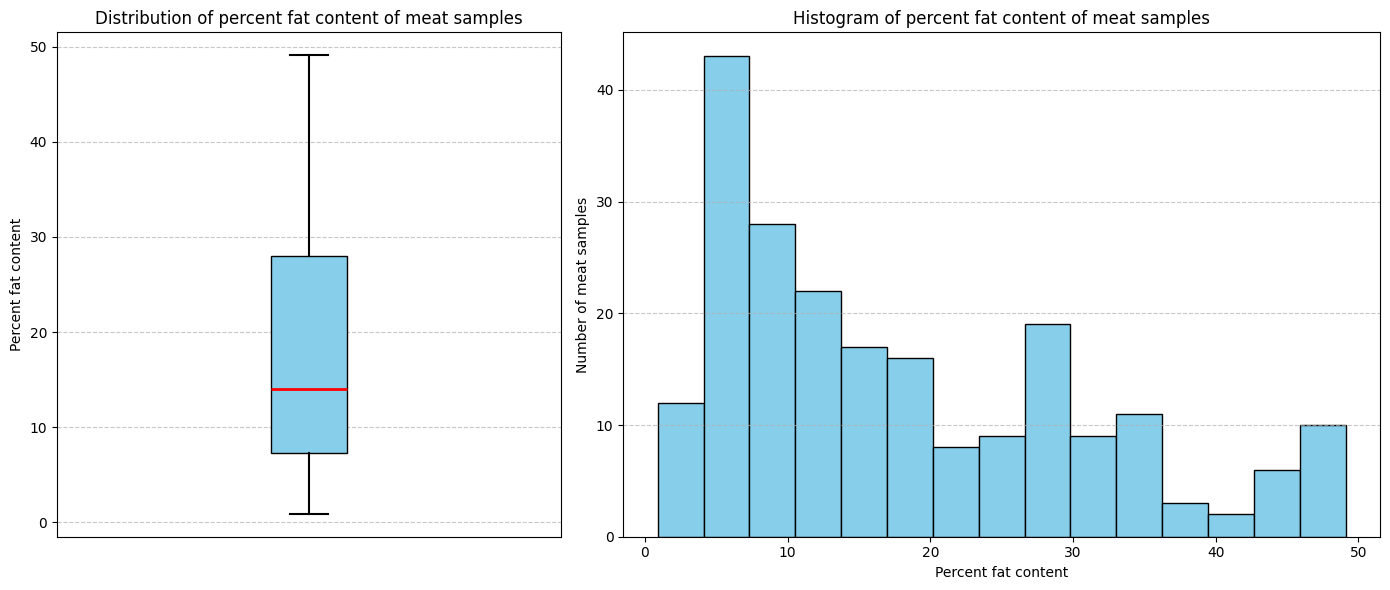

In [6]:
# --- Boxplot + Histogram Side by Side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.5]})

# --- Boxplot (unchanged) ---
axes[0].boxplot(fat, patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='black'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='orange', markersize=6, linestyle='none'))

axes[0].set_ylabel("Percent fat content")
axes[0].set_title("Distribution of percent fat content of meat samples")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].set_xticks([])

# --- Histogram ---
axes[1].hist(fat, bins=15, color='skyblue', edgecolor='black')
axes[1].set_xlabel("Percent fat content")
axes[1].set_ylabel("Number of meat samples")
axes[1].set_title("Histogram of percent fat content of meat samples")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Low-dimensional regression coefficient function $\beta$

### Computations

Here, we'll use the naive functional linear regression method of taking $X(t)$, projecting it onto a cubic B-spline basis consisting of 20 smooth functions, and getting 5 cubic B-spline basis functions for $\beta(t)$.

First, we smooth each $X(t)$ using this 20-B-spline basis. Thus, $K_{X} = 20$.

In [7]:
K_X = 20
X_spline_basis = skfda.representation.basis.BSplineBasis(n_basis=K_X)
tecator_spline_20 = tecator_fdatagrid.to_basis(X_spline_basis)
tecator_spline_20

FDataBasis(
    basis=BSplineBasis(domain_range=((850.0, 1050.0),), n_basis=20, order=4, knots=(np.float64(850.0), np.float64(861.7647058823529), np.float64(873.5294117647059), np.float64(885.2941176470588), np.float64(897.0588235294117), np.float64(908.8235294117648), np.float64(920.5882352941177), np.float64(932.3529411764706), np.float64(944.1176470588235), np.float64(955.8823529411765), np.float64(967.6470588235294), np.float64(979.4117647058824), np.float64(991.1764705882354), np.float64(1002.9411764705883), np.float64(1014.7058823529412), np.float64(1026.4705882352941), np.float64(1038.235294117647), np.float64(1050.0))),
    coefficients=[[2.61799513 2.61732618 2.62210333 ... 2.93360215 2.85958313 2.81900986]
     [2.83480201 2.84136832 2.86050118 ... 3.26151256 3.21546189 3.17889839]
     [2.58291322 2.58585166 2.59333205 ... 2.64525164 2.57810662 2.54822957]
     ...
     [2.56906277 2.56811629 2.57470713 ... 2.90984263 2.85092334 2.81066114]
     [2.65927487 2.65784437 2.6665

Generate the $\beta$ 5-B-spline basis. Thus, $K_{\beta} = 5$.

In [8]:
K_beta = 5
beta_spline_basis = skfda.representation.basis.BSplineBasis(n_basis=K_beta)

Compute the $K_{X} \times K_{\beta}$ $L_{2}$ inner product matrix $J_{\psi \theta}$. The R version seems to match when we use the identity matrix for $J$ instead of the numeric integration matrix.

In [9]:
J = X_spline_basis.inner_product_matrix(beta_spline_basis)
# J = np.eye(65, 5)

print(J.shape)
print(J)

(20, 5)
[[1.37078442e-02 9.78197100e-04 1.96699889e-05 1.71043382e-07
  0.00000000e+00]
 [2.37327823e-02 5.40941799e-03 2.64433068e-04 5.13130145e-06
  0.00000000e+00]
 [2.83009235e-02 1.44287066e-02 1.34183533e-03 4.61817131e-05
  0.00000000e+00]
 [2.69273596e-02 2.73224698e-02 4.33423929e-03 2.39460734e-04
  0.00000000e+00]
 [1.64629255e-02 3.31174196e-02 8.52480215e-03 7.18382203e-04
  0.00000000e+00]
 [9.15937309e-03 3.46020761e-02 1.34337472e-02 1.62833299e-03
  0.00000000e+00]
 [4.44199662e-03 3.27821745e-02 1.84863687e-02 3.11298955e-03
  0.00000000e+00]
 [1.73609032e-03 2.86634499e-02 2.31079609e-02 5.31602830e-03
  0.00000000e+00]
 [4.66949323e-04 2.32516355e-02 2.67238197e-02 8.38112392e-03
  8.90850925e-10]
 [6.18099112e-05 1.75485824e-02 2.87631237e-02 1.24480687e-02
  1.94472762e-06]
 [1.94472762e-06 1.24480687e-02 2.87631237e-02 1.75485824e-02
  6.18099112e-05]
 [8.90850925e-10 8.38112392e-03 2.67238197e-02 2.32516355e-02
  4.66949323e-04]
 [0.00000000e+00 5.31602830e-03 

Construct the matrix $Z$ by prepending a column of ones.

In [10]:
Z = np.concatenate((np.ones((N, 1)), tecator_spline_20.coefficients @ J), axis=1)
print(Z.shape)
print(Z)

(215, 6)
[[1.         0.33018926 0.70304932 0.7655717  0.7981084  0.37719781]
 [1.         0.36201077 0.77831989 0.83286111 0.85644649 0.41421437]
 [1.         0.32619947 0.68499584 0.72954774 0.74025602 0.34143477]
 ...
 [1.         0.32526693 0.7008836  0.76068572 0.78582998 0.37258758]
 [1.         0.33735624 0.72922839 0.78691911 0.80832815 0.38470786]
 [1.         0.36939418 0.81256188 0.88389003 0.91376546 0.4398778 ]]


Compute the estimated coefficient vector $\hat{\zeta}$ via the equation
$$Z'Z \hat{\zeta} = Z'y,$$
which has solution
$$\hat{\zeta} = (Z'Z)^{-1}Z'y.

In [11]:
zeta_hat = np.linalg.inv(Z.T @ Z) @ Z.T @ fat
print("Intercept:", zeta_hat[0])
print("Coefficients:", zeta_hat[1:])

Intercept: 41.09121977440813
Coefficients: [  978.13466646 -4087.16347199  7363.95062583 -5438.88710183
  3247.96401418]


### Plots

Next, we'll plot the coefficient function.

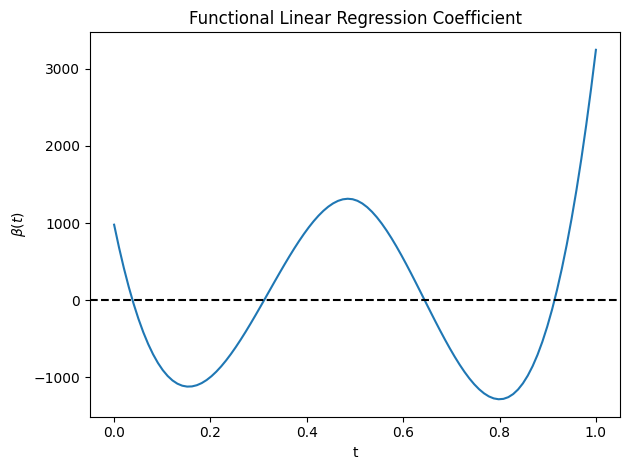

In [12]:
# Create an array consisting of the days in the year as defined by the basis.
t_array = np.linspace(*beta_spline_basis.domain_range[0], n)

# Evaluate the basis functions at each day of the year.
Phi = beta_spline_basis(t_array)
Phi = Phi[..., 0] # Shape: (K_beta, n)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

plt.figure()
plt.plot(t_array, beta_values)
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

What does $X_{1}(t) \cdot \beta(t)$ look like? This is the function that is integrated and summed with $\alpha$ in the functional linear regression model.

In [13]:
tecator_df.iloc[0]

850.0        2.61776
852.0202     2.61814
854.0404     2.61859
856.0606     2.61912
858.0808     2.61981
              ...   
1041.9192    2.89966
1043.9394    2.87964
1045.9596    2.85960
1047.9798    2.83940
1050.0       2.81920
Name: 0, Length: 100, dtype: float64

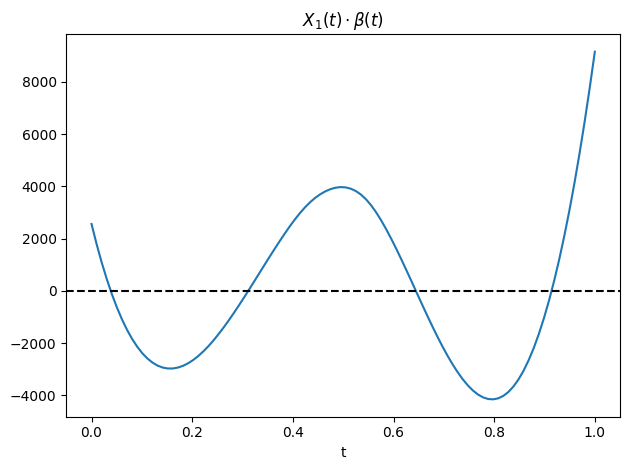

In [14]:
contributions = tecator_df.iloc[0] * beta_values

plt.figure()
plt.plot(t_array, contributions)
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
# plt.ylabel(r"$\beta(t)$")
plt.title(r"$X_{1}(t) \cdot \beta(t)$")
plt.tight_layout()
plt.show()

### Fit assessment

We compute $R^{2}$ on the whole data set and the $F$-score.

Residuals:
$$\hat{y} = Z \hat{\zeta}$$

In [15]:
y_hat = Z @ zeta_hat
y_res = fat - y_hat

Recall the equation for $R^{2}$:
$$R^{2} = 1 - \frac{SS_{Res}}{SS_{Total}}$$

In [16]:
SS_tot = np.sum((fat - fat.mean())**2)
SS_res = np.sum(y_res**2)

R2 = 1 - SS_res/SS_tot
R2

np.float64(0.857349770398327)

Recall the equation for the $F$ statistic with $N$ observations and $n$ predictors:
$$F = \frac{(SS_{T}-SS_{Res})/n}{SS_{Res}/(N-n-1)}.$$

In [17]:
F = ((SS_tot - SS_res) / K_beta) / (SS_res / (N - K_beta - 1))
F

np.float64(251.2244144486802)

## Coefficient $\beta$ estimate using a roughness penalty

Here, we'll use the more advanced functional linear regression method of taking $X(t)$, projecting it onto a B-spline basis consisting of 50 smooth functions, and getting 25 B-spline coefficients for $\beta(t)$ using a roughness penalty.

### Computations

Again, we smooth each $X(t)$ using this 50-B-spline basis.

In [18]:
K_X = 15
X_spline_basis = skfda.representation.basis.BSplineBasis(n_basis=K_X)
tecator_spline_50 = tecator_fdatagrid.to_basis(X_spline_basis)
tecator_spline_50

FDataBasis(
    basis=BSplineBasis(domain_range=((850.0, 1050.0),), n_basis=15, order=4, knots=(np.float64(850.0), np.float64(866.6666666666666), np.float64(883.3333333333334), np.float64(900.0), np.float64(916.6666666666666), np.float64(933.3333333333334), np.float64(950.0), np.float64(966.6666666666666), np.float64(983.3333333333334), np.float64(1000.0), np.float64(1016.6666666666667), np.float64(1033.3333333333333), np.float64(1050.0))),
    coefficients=[[2.6171575  2.62108229 2.61716346 ... 2.99052109 2.87014022 2.82050722]
     [2.83382996 2.84872546 2.86319962 ... 3.29817832 3.22321557 3.18051077]
     [2.58287999 2.58738746 2.59736444 ... 2.69565367 2.5871432  2.54913092]
     ...
     [2.56755461 2.57473134 2.56505983 ... 2.95608107 2.85997856 2.81239262]
     [2.65724417 2.66668775 2.65344377 ... 3.05529587 2.96721091 2.91691617]
     [2.88831168 2.90454741 2.89041716 ... 3.50126653 3.40912622 3.34776057]],
    dataset_name=Spectrometric curves,
    argument_names=('Wavelengt

Generate the $\beta$ 25-B-spline basis.

In [19]:
K_beta = 25
beta_spline_basis = skfda.representation.basis.BSplineBasis(n_basis=K_beta)

Compute the $K_{X} \times K_{\beta}$ $L_{2}$ inner product matrix $J_{\psi \theta}$.

In [20]:
J = X_spline_basis.inner_product_matrix(beta_spline_basis)
# J = np.eye(65, 35)

print(J.shape)
print(J)

(15, 25)
[[8.26812181e-03 8.29910140e-03 3.66214928e-03 6.01510063e-04
  2.45078379e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.79694010e-03 1.08804043e-02 1.57156968e-02 1.04082096e-02
  1.78737633e-03 7.79111160e-05 1.28491654e-07 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.89792851e-04 3.28431906e-03 1.23549478e-02 2.30831240e-02
  1.69101565e-02 5.75972116e-03 7.92965907e-04 2.49612451e-05
  1.14343767e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.000000

Construct the matrix $Z$ by prepending a column of ones.

In [21]:
Z = np.concatenate((np.ones((N, 1)), tecator_spline_50.coefficients @ J), axis=1)
print(Z.shape)
print(Z)

(215, 26)
[[1.         0.02975174 0.05953372 ... 0.09983879 0.06529065 0.0322423 ]
 [1.         0.03225365 0.06468972 ... 0.11108293 0.07319477 0.03629769]
 [1.         0.02936808 0.05880935 ... 0.09004351 0.05891148 0.02911891]
 ...
 [1.         0.0291966  0.05843806 ... 0.09907114 0.06498258 0.03213624]
 [1.         0.03022187 0.06050026 ... 0.10257711 0.06736633 0.03332992]
 [1.         0.03286873 0.06585645 ... 0.1176682  0.07733312 0.03826138]]


New here, we need to compute the penalty matrix $R$ and its modification $R_{0}$ (add a leading row and column of zeros):

$$R = \int [D^{2} \phi(s)][D^{2} \phi'(s)] \,ds.$$

In [22]:
# From ChatGPT.
I = np.eye(K_beta)
deriv_basis, C = beta_spline_basis.derivative_basis_and_coefs(I, order=2)
G = deriv_basis.gram_matrix()
R = C @ G @ C.T

R_0 = np.concatenate((np.zeros((K_beta, 1)), R), axis=1)
R_0 = np.concatenate((np.zeros((1, K_beta+1)), R_0), axis=0)

print("Symmetric matrix:", np.allclose(R, R.T))
print(R_0)

Symmetric matrix: True
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.27776000e+05 -1.75692000e+05  3.72680000e+04
   1.06480000e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.75692000e+05  2.55552000e+05 -7.18740000e+04
  -1.06480000e+04  2.66200000e+03  0.00000000e+00

In [23]:
# Legacy from Fourier basis.
# R = np.eye(35)
# R = np.diag((beta_fourier_basis.derivative(order=2)(day_array)[:,:,0]**2).sum(axis=1) * 365/(2*np.pi))
# L = 365
# omegas = [0] + [((((k+1)//2) / L)**4) for k in range(1, 35)]
# R = np.diag(omegas)
# R_0 = np.concatenate((np.zeros((35, 1)), R), axis=1)
# R_0 = np.concatenate((np.zeros((1, 36)), R_0), axis=0)
# R_0

Compute the estimated coefficient vector $\hat{\zeta}$ via the equation
$$(Z'Z + \lambda R_{0}) \hat{\zeta} = Z'y,$$
which has solution
$$\hat{\zeta} = (Z'Z + \lambda R_{0})^{-1}Z'y.

In [24]:
lam = 1e-14

zeta_hat = np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ fat
print("Intercept:", zeta_hat[0])
print("Coefficients:", zeta_hat[1:])

hat_matrix = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
df = np.linalg.trace(hat_matrix)
print("Degrees of freedom:", df)

Intercept: 9.689237645462537
Coefficients: [ 19237.73042046  -6512.67020307 -59471.18829256  37846.65497049
  51755.62739154 -30166.8339042  -33387.72958298   6739.27786108
  11346.57007985  -1001.01017732    726.84434692   5338.43114605
  -4814.75752597 -14322.52576101   8237.03069576  34744.86805822
  -3287.89348429 -63861.60234313 -24772.89490816  77740.12709696
  68380.70537773 -77148.2037089  -98602.79450805  63872.2288207
 140189.09010151]
Degrees of freedom: 15.087503061055394


These values are all pretty close to those from R.

Furthermore, we can compute pointwise confidence intervals using the sampling variance of $\hat{\zeta}$:

$$\text{Var}[\hat{\zeta}] = \sigma_{e}^{2} (Z'Z + \lambda R_{0})^{-1} Z'Z (Z'Z + \lambda R_{0})^{-1}.$$

At any $t$,

$$\text{Var}(\hat{\beta}(t)) = \phi(t)' \text{Var}[\hat{\zeta}] \phi(t).$$

Then, a 95% confidence interval for $\beta(t)$ is:

$$\hat{\beta}(t) \pm 1.96 \sqrt{\text{Var}(\hat{\beta}(t))}.$$

The only thing left to do is get $\sigma_{e}^{2}$, the estimate of the mean squared residual.

In [25]:
y_hat = Z @ zeta_hat
y_res = fat - y_hat

rss = np.sum(y_res**2)
sigma2e = rss / (len(fat) - df)

var_zeta = sigma2e * np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ Z @ np.linalg.inv(Z.T @ Z + lam * R_0)
var_zeta = var_zeta[1:, 1:]

In [26]:
print(np.linalg.norm(Z.T @ Z, 2))
print(np.linalg.norm(R_0, 2))
print(np.linalg.norm(lam * R_0, 2))


311.29001441544517
397437.9592295448
3.974379592295451e-09


### Plots

Next, we'll plot the coefficient function along with the 95% confidence intervals.

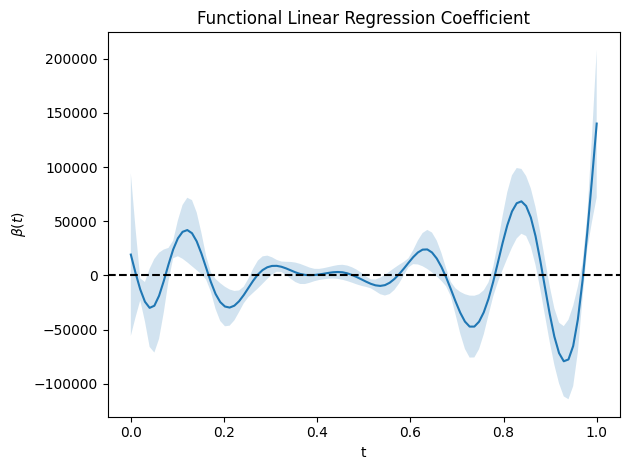

In [27]:
# Create an array consisting of the days in the year as defined by the basis.
day_array = np.linspace(*beta_spline_basis.domain_range[0], n)

# Evaluate the basis functions at each day of the year.
Phi = beta_spline_basis(day_array)
Phi = Phi[..., 0] # Shape: (5, 365)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

# Add and subtract the confidence values above.
lower_beta_values = beta_values - 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))
upper_beta_values = beta_values + 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))

plt.figure()
plt.plot(day_array, beta_values)
# plt.plot(day_array, lower_beta_values, c="black")
# plt.plot(day_array, upper_beta_values, c="black")
plt.fill_between(day_array, lower_beta_values, upper_beta_values, alpha=0.2, label="95% pointwise CI")
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

What does $X_{1}(t) \cdot \beta(t)$ look like? This is the function that is integrated and summed with $\alpha$ in the functional linear regression model.

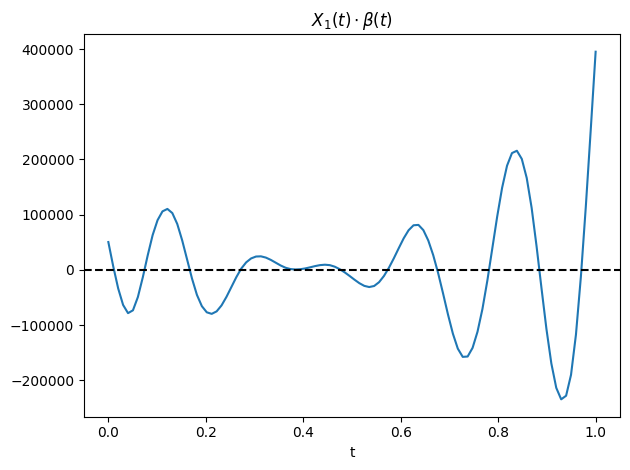

In [28]:
contributions = tecator_df.iloc[0] * beta_values

plt.figure()
plt.plot(day_array, contributions)
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
# plt.ylabel(r"$\beta(t)$")
plt.title(r"$X_{1}(t) \cdot \beta(t)$")
plt.tight_layout()
plt.show()

### Fit assessment

We compute $R^{2}$ on the whole data set and the $F$-score.

In [29]:
y_hat = Z @ zeta_hat
y_res = fat - y_hat

In [30]:
SS_tot = np.sum((fat - fat.mean())**2)
SS_res = np.sum(y_res**2)

R2 = 1 - SS_res/SS_tot
R2

np.float64(0.9637833279046952)

In [31]:
F = ((SS_tot - SS_res) / K_beta) / (SS_res / (N - K_beta - 1))
F

np.float64(201.18364105309635)

## Cross-validation

### Computations

We can choose the best smoothing parameter $\lambda$ using leave-one-out cross validation, referred to as CV throughout. Let $S$ be the hat matrix that sends $y$ to $\hat{y}$ for a particular value of $\lambda$. Then

$$\text{CV}(\lambda) = \sum_{i=1}^{N} \left( \frac{y_{i} - \hat{y}_{i}}{1 - S_{ii}} \right)^{2}.$$

Let's compute CV scores for various lambda values, spaced logarithmically.

In [32]:
# Define the grid of lambda values.
lambda_low = -20
lambda_high = 5
range_values = np.arange(lambda_low, lambda_high, 0.25)
lambda_values = 10**range_values

# For each, compute the CV score.
scores = {} # Empty dict to score lambdas and scores
for lam in lambda_values:
    S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
    # S1 = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    diags = np.diag(S)
    y_hat_lam = S @ fat
    y_res_lam = fat - y_hat_lam
    
    scores[lam] = ((y_res_lam / (1 - diags))**2).sum()

### Plots

First, $\text{CV}(\lambda)$.

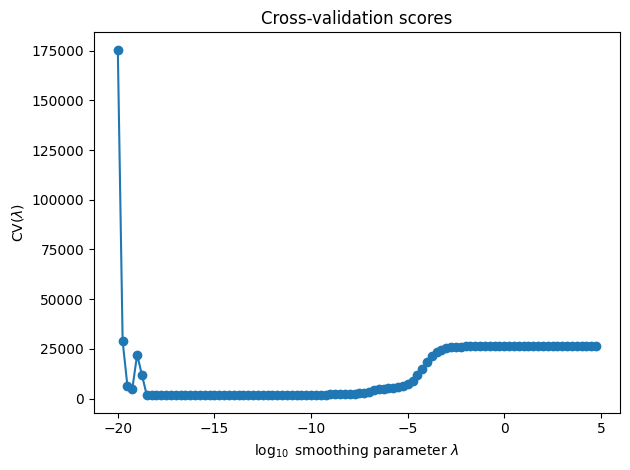

In [33]:
plt.figure()
plt.plot(range_values, scores.values(), marker="o")
plt.xlabel(r"$\log_{10}$ smoothing parameter $\lambda$")
plt.ylabel(r"$\text{CV}(\lambda)$")
plt.title("Cross-validation scores")
plt.tight_layout()
plt.show()

What's the minimum $\text{CV}(\lambda)$?

In [34]:
from operator import itemgetter

min_cv = min(scores.items(), key=itemgetter(1))
min_cv

(np.float64(1e-18), np.float64(1582.9841797134955))

Now, deleted residuals:

$$\frac{y_{i} - \hat{y}_{i}}{1 - S_{ii}}.$$

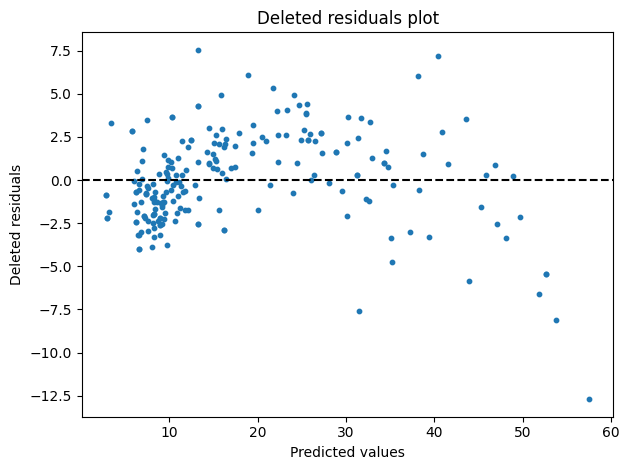

In [35]:
lam = 1e-18
S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
diags = np.diag(S)
y_hat_lam = S @ fat
y_res_lam = fat - y_hat_lam

y_del_res_lam = y_res_lam / (1 - diags)

plt.figure()
plt.scatter(y_hat_lam, y_del_res_lam, s=10)
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Deleted residuals")
plt.title("Deleted residuals plot")
plt.tight_layout()
plt.show()

## Scalar response models by functional principal components

We skip this for now.

## More cross-validation

Let's examine the coefficient functional $\beta(t)$ and corresponding overall and predictive $R^{2}$ scores at some different values.

Recall, for LOOCV, predictive $R^{2}$ can be found by

$$R_{pred}^{2} = 1 - \frac{\sum_{i=1}^{n} (y_{i} - \hat{y}_{i}^{(-i)})}{SS_{T}}.$$

### Matrix formation

In [46]:
def matrix_formation(fdatagrid, K_X, K_beta):
    # Form the X basis and coefficients.
    X_basis = skfda.representation.basis.BSplineBasis(n_basis=K_X)
    X_basis_representation = fdatagrid.to_basis(X_basis)

    # Form the beta basis.
    beta_basis = skfda.representation.basis.BSplineBasis(n_basis=K_beta)

    # Compute the K_X x K_beta L2 inner product matrix J.
    J = X_basis.inner_product_matrix(beta_basis)

    # Construct the matrix Z by prepending a column of ones.
    Z = np.concatenate((np.ones((N, 1)), X_basis_representation.coefficients @ J), axis=1)

    # Form the penalty matrix R. From ChatGPT.
    I = np.eye(K_beta)
    deriv_basis, C = beta_basis.derivative_basis_and_coefs(I, order=2)
    G = deriv_basis.gram_matrix()
    R = C @ G @ C.T
    R_0 = np.concatenate((np.zeros((K_beta, 1)), R), axis=1)
    R_0 = np.concatenate((np.zeros((1, K_beta+1)), R_0), axis=0)

    return X_basis, X_basis_representation, beta_basis, J, Z, R_0

### Evaluation function

In [36]:
def coef_computation_and_metric_evaluation(lam, Z, R_0, y, verbose=False):
    # Easy, reused computations.
    SS_tot = np.sum((y - y.mean())**2)
    A = Z.T @ Z + lam * R_0

    # Beta basis coefficients.
    zeta_hat = np.linalg.solve(A, Z.T @ y)

    # Hat matrix. TODO: maybe follow ChatGPT's advice of not actually computing this n x n matrix.
    S = Z @ np.linalg.solve(A, Z.T)

    # Degrees of freedom.
    df = np.trace(S)

    # Overall R^2.
    y_hat = S @ y
    y_res = y - y_hat
    SS_res = np.sum(y_res**2)
    R2 = 1 - SS_res / SS_tot

    # LOOCV score and Predictive R^2.
    S_diag = np.diag(S)
    y_del_res = y_res / (1 - S_diag + 1e-6)
    CV_score = (y_del_res**2).sum()
    R2_pred = 1 - CV_score / SS_tot

    # Compute confidence limits.
    sigma2e = SS_res / (y.shape[0] - df)
    # We need to compute A^{-1} Z' Z A^{-1}.
    # We could use sigma2e * np.linalg.solve(A, np.linalg.solve(A, Z.T @ Z)), but
    # oftentimes this loses symmetry and positive semi-definiteness. So, ChatGPT
    # recommended this.
    U = np.linalg.solve(A, Z.T)
    var_zeta = sigma2e * (U @ U.T)
    var_zeta = 0.5 * (var_zeta + var_zeta.T)
    var_zeta = var_zeta[1:, 1:]

    if verbose:
        print("Degrees of freedom:", round(df, 1))
        print()
        print("R^2:", round(R2, 2))
        print("Predictive R^2:", round(R2_pred, 2))
        print("CV score:", round(CV_score, 1))

    return zeta_hat, var_zeta, df, R2, R2_pred, CV_score

### $\lambda = 10^{-18}$

In [48]:
lam = 1e-14
K_X = 15
K_beta = 25

X_basis, X_basis_representation, beta_basis, J, Z, R_0 = matrix_formation(tecator_fdatagrid, K_X=K_X, K_beta=K_beta)
zeta_hat, var_zeta, df, R2, R2_pred, CV_score = coef_computation_and_metric_evaluation(lam, Z, R_0, fat, verbose=True)

Degrees of freedom: 15.1

R^2: 0.96
Predictive R^2: 0.95
CV score: 1584.1


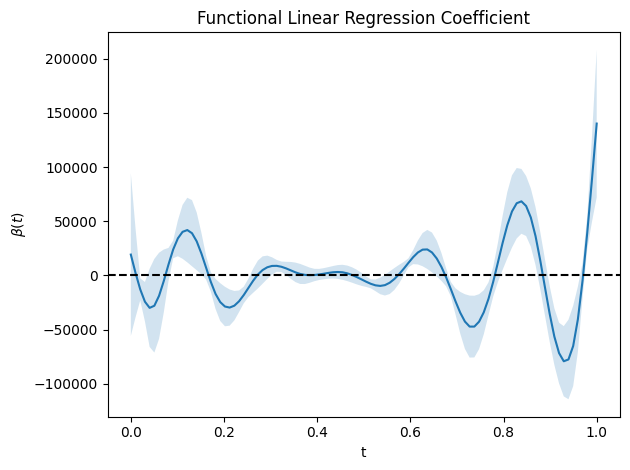

In [38]:
# Create an array consisting of the days in the year as defined by the basis.
t_array = np.linspace(*beta_spline_basis.domain_range[0], n)

# Evaluate the basis functions at each day of the year.
Phi = beta_spline_basis(t_array)
Phi = Phi[..., 0] # Shape: (K_beta, n)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

# Add and subtract the confidence values above.
lower_beta_values = beta_values - 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))
upper_beta_values = beta_values + 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))

plt.figure()
plt.plot(t_array, beta_values)
plt.fill_between(t_array, lower_beta_values, upper_beta_values, alpha=0.2, label="95% pointwise CI")
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

### $\lambda = 0$

In [39]:
lam = 0.

zeta_hat, var_zeta, df, R2, R2_pred, CV_score = coef_computation_and_metric_evaluation(lam, Z, R_0, fat, verbose=True)

Degrees of freedom: 16.0

R^2: 0.96
Predictive R^2: 0.95
CV score: 1596.9


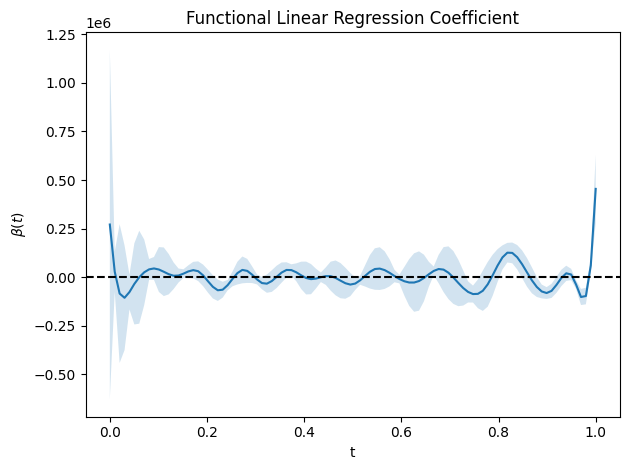

In [40]:
# Create an array consisting of the days in the year as defined by the basis.
t_array = np.linspace(*beta_spline_basis.domain_range[0], n)

# Evaluate the basis functions at each day of the year.
Phi = beta_spline_basis(t_array)
Phi = Phi[..., 0] # Shape: (K_beta, n)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

# Add and subtract the confidence values above.
lower_beta_values = beta_values - 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))
upper_beta_values = beta_values + 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))

plt.figure()
plt.plot(t_array, beta_values)
plt.fill_between(t_array, lower_beta_values, upper_beta_values, alpha=0.2, label="95% pointwise CI")
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

### Predictive $R^{2}$ plot

In [41]:
# Define the grid of lambda values.
lambda_low = -20
lambda_high = 5
range_values = np.arange(lambda_low, lambda_high, 0.5)
lambda_values = 10**range_values

# For each, compute the CV score.
CV_scores = {} # Empty dict to score lambdas and scores
R2pred_scores = {}
for log_lam in range_values:
    result = coef_computation_and_metric_evaluation(10**log_lam, Z, R_0, fat, verbose=False)
    CV_scores[log_lam] = result[-1]
    R2pred_scores[log_lam] = result[-2]

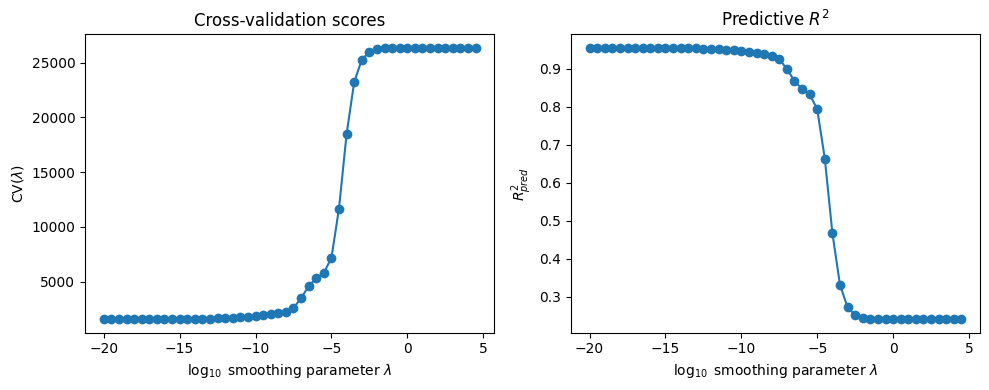

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# ---- CV plot ----
axes[0].plot(range_values, CV_scores.values(), marker="o")
axes[0].set_xlabel(r"$\log_{10}$ smoothing parameter $\lambda$")
axes[0].set_ylabel(r"$\mathrm{CV}(\lambda)$")
axes[0].set_title("Cross-validation scores")

# ---- Predictive R^2 plot ----
axes[1].plot(range_values, R2pred_scores.values(), marker="o")
axes[1].set_xlabel(r"$\log_{10}$ smoothing parameter $\lambda$")
axes[1].set_ylabel(r"$R_{pred}^{2}$")
axes[1].set_title("Predictive $R^2$")

plt.tight_layout()
plt.show()


In [43]:
from operator import itemgetter

min_cv = min(scores.items(), key=itemgetter(1))
min_cv

(np.float64(1e-18), np.float64(1582.9841797134955))

### Remarks

## $(K_{X}, K_{\beta}, \lambda)$-sweep

Let's do a huge sweep over these three parameters to see what happens.

A reasonable starting grid.

In [60]:
# User-defined parameters.
KX_values = np.arange(5, 50, 5)
Kbeta_values = np.arange(5, 50, 5)
log10_lams = np.arange(-15, 5, 1.)

# Consequences.
lam_values = 10 ** log10_lams

In [61]:
import numpy as np
import time

def sweep_r2pred(
    tecator_fdatagrid,
    y,
    KX_values,
    Kbeta_values,
    lam_values,
):
    KX_values = list(KX_values)
    Kbeta_values = list(Kbeta_values)
    lam_values = np.asarray(lam_values)

    # Store predictive R^2 in array: (nKX, nKb, nLam)
    r2pred = np.empty((len(KX_values), len(Kbeta_values), len(lam_values)), dtype=float)

    # Cache Z and R0 for each (KX, Kbeta)
    cache = {}

    t0 = time.time()
    for i, KX in enumerate(KX_values):
        for j, Kb in enumerate(Kbeta_values):
            key = (KX, Kb)
            if key not in cache:
                # Build matrices once for this (KX, Kbeta)
                _, _, _, _, Z, R_0 = matrix_formation(tecator_fdatagrid, K_X=KX, K_beta=Kb)
                cache[key] = (Z, R_0)

            Z, R_0 = cache[key]

            # Sweep lambdas (cheap, relative)
            for k, lam in enumerate(lam_values):
                _, _, _, _, R2_pred, _ = coef_computation_and_metric_evaluation(
                    lam, Z, R_0, y, verbose=False
                )
                r2pred[i, j, k] = R2_pred

    print(f"Total sweep time: {time.time() - t0:.1f}s")
    return r2pred


In [62]:
r2pred = sweep_r2pred(
    tecator_fdatagrid=tecator_fdatagrid,
    y=fat,
    KX_values=KX_values,
    Kbeta_values=Kbeta_values,
    lam_values=lam_values,
)

Total sweep time: 81.1s


In [65]:
r2pred

array([[[0.84513078, 0.84513078, 0.84513078, ..., 0.23780955,
         0.23780943, 0.23780941],
        [0.84513078, 0.84513078, 0.84513078, ..., 0.23780964,
         0.23780944, 0.23780942],
        [0.84513078, 0.84513078, 0.84513078, ..., 0.23780964,
         0.23780944, 0.23780942],
        ...,
        [0.84513078, 0.84513078, 0.84513078, ..., 0.23780964,
         0.23780946, 0.23780954],
        [0.84513078, 0.84513078, 0.84513078, ..., 0.23780964,
         0.23780941, 0.2378094 ],
        [0.84513078, 0.84513078, 0.84513078, ..., 0.23780964,
         0.23780945, 0.23780944]],

       [[0.85000414, 0.85000414, 0.85000414, ..., 0.24167702,
         0.24167689, 0.24167688],
        [0.94323795, 0.94325046, 0.94335329, ..., 0.2416772 ,
         0.24167691, 0.24167688],
        [0.94323703, 0.94324148, 0.94328325, ..., 0.2416772 ,
         0.24167691, 0.24167687],
        ...,
        [0.94323701, 0.94324132, 0.94328177, ..., 0.2416772 ,
         0.24167693, 0.24167704],
        [0.9

In [63]:
import matplotlib.pyplot as plt

def plot_small_multiples_heatmaps(r2pred, KX_values, Kbeta_values, log10_lams):
    KX_values = list(KX_values)
    Kbeta_values = list(Kbeta_values)
    log10_lams = np.asarray(log10_lams)

    n_panels = len(KX_values)
    ncols = min(3, n_panels)
    nrows = int(np.ceil(n_panels / ncols))

    # Use common color scale across panels (important!)
    vmin = np.nanmin(r2pred)
    vmax = np.nanmax(r2pred)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows), constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    # imshow wants extents for "data coordinates"
    x0, x1 = log10_lams.min(), log10_lams.max()
    y0, y1 = min(Kbeta_values), max(Kbeta_values)

    last_im = None
    for idx, KX in enumerate(KX_values):
        ax = axes[idx]
        # Slice: (nKb, nLam)
        M = r2pred[idx, :, :]

        last_im = ax.imshow(
            M,
            origin="lower",
            aspect="auto",
            extent=[x0, x1, y0, y1],
            vmin=vmin,
            vmax=vmax,
            cmap="seismic"
        )
        ax.set_title(f"$K_X = {KX}$")
        ax.set_xlabel(r"$\log_{10}\lambda$")
        ax.set_ylabel(r"$K_\beta$")

        # Put ticks exactly at your sampled values (optional but nice)
        ax.set_yticks(Kbeta_values)
        ax.set_xticks(np.round(log10_lams, 1))

    # Turn off unused axes
    for ax in axes[n_panels:]:
        ax.axis("off")

    # One shared colorbar
    fig.colorbar(last_im, ax=axes[:n_panels], shrink=0.9, label=r"Predictive $R^2$")

    plt.show()


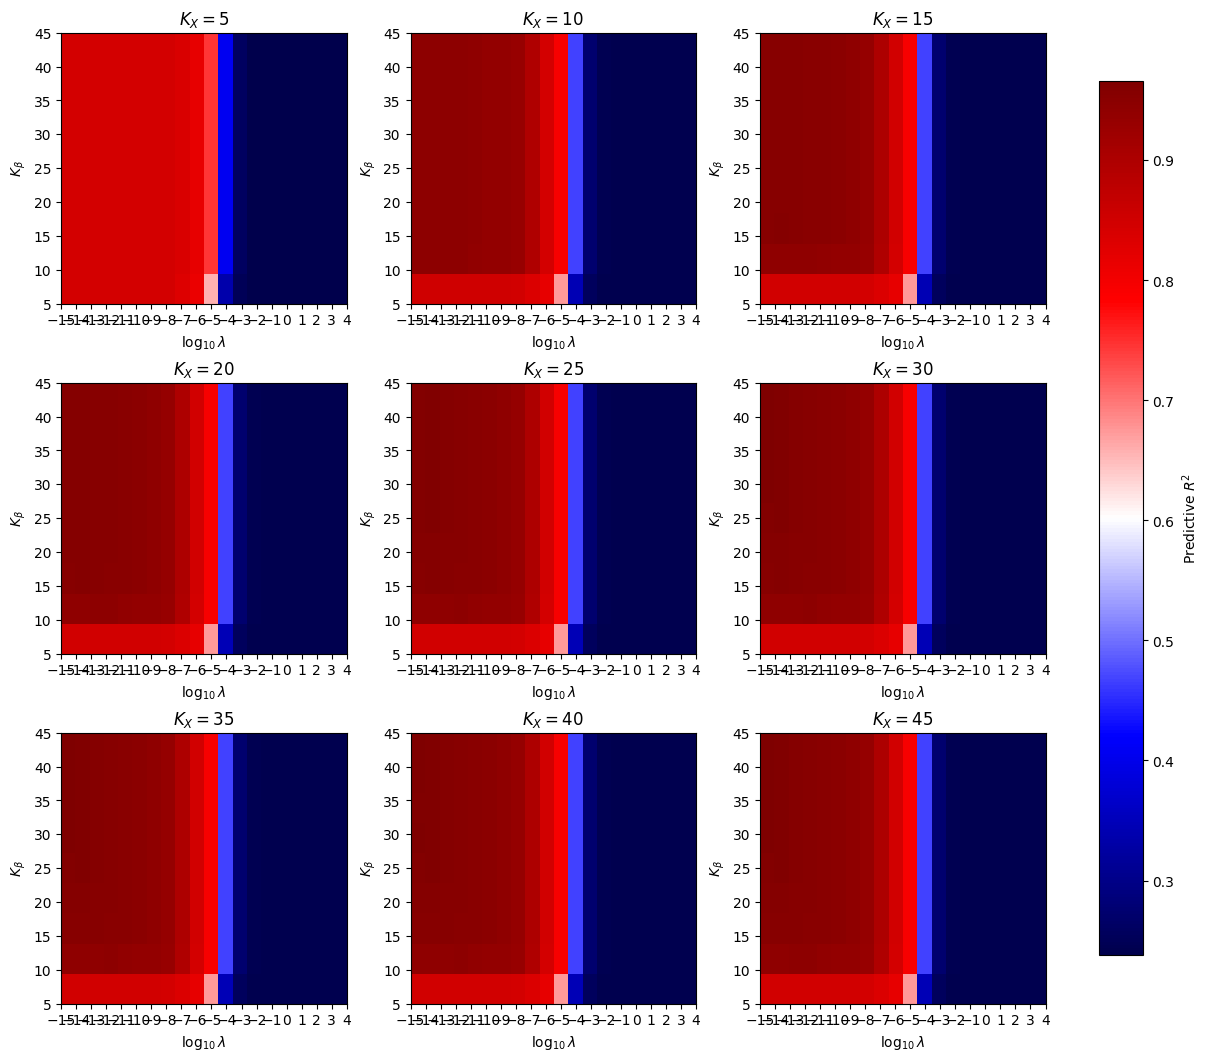

In [64]:
plot_small_multiples_heatmaps(r2pred, KX_values, Kbeta_values, log10_lams)

## 2

In [ ]:
import numpy as np
import pandas as pd
import time
from pathlib import Path

def sweep_fda_to_tidy_df(
    tecator_fdatagrid,
    y,
    KX_values,
    Kbeta_values,
    lam_values,
    *,
    cache_matrices=True,
    include_timing=True,
    verbose_progress=True,
):
    """
    Sweep over (K_X, K_beta, lam) and return a tidy (long) DataFrame.

    Assumes you have:
      - matrix_formation(tecator_fdatagrid, K_X=..., K_beta=...) -> (..., Z, R_0)
      - coef_computation_and_metric_evaluation(lam, Z, R_0, y, verbose=False)
        -> (zeta_hat, var_zeta, df, R2, R2_pred, CV_score)
    """
    y = np.asarray(y).ravel()
    KX_values = list(KX_values)
    Kbeta_values = list(Kbeta_values)
    lam_values = np.asarray(lam_values, dtype=float)
    log10_lams = np.log10(lam_values)

    # Cache for (Z, R_0) keyed by (KX, Kbeta)
    mat_cache = {} if cache_matrices else None

    rows = []
    total = len(KX_values) * len(Kbeta_values) * len(lam_values)
    done = 0
    t0_all = time.time()

    for KX in KX_values:
        for Kb in Kbeta_values:
            key = (KX, Kb)

            if cache_matrices and key in mat_cache:
                Z, R_0 = mat_cache[key]
            else:
                # NOTE: adjust unpacking if your matrix_formation returns different items.
                # You said: X_basis, X_basis_representation, beta_basis, J, Z, R_0 = matrix_formation(...)
                _, _, _, _, Z, R_0 = matrix_formation(tecator_fdatagrid, K_X=KX, K_beta=Kb)

                if cache_matrices:
                    mat_cache[key] = (Z, R_0)

            for lam, loglam in zip(lam_values, log10_lams):
                t0 = time.time()

                _, _, df, R2, R2_pred, CV_score = coef_computation_and_metric_evaluation(
                    lam, Z, R_0, y, verbose=False
                )

                row = {
                    "K_X": KX,
                    "K_beta": Kb,
                    "lam": lam,
                    "log10_lam": float(loglam),
                    "R2_pred": float(R2_pred),
                    "CV_score": float(CV_score),
                    "df": float(df),
                    "R2": float(R2),
                }

                if include_timing:
                    row["time_sec"] = time.time() - t0

                rows.append(row)

                done += 1
                if verbose_progress and (done % max(1, total // 10) == 0 or done == total):
                    elapsed = time.time() - t0_all
                    print(f"{done}/{total} runs ({done/total:.0%}) | elapsed {elapsed:.1f}s")

    df = pd.DataFrame(rows)

    # Helpful sorting for plotting/pivoting
    df = df.sort_values(["K_X", "K_beta", "log10_lam"]).reset_index(drop=True)
    return df


In [67]:
# User-defined parameters.
KX_values = np.arange(5, 50, 5)
Kbeta_values = np.arange(5, 50, 5)
log10_lams = np.arange(-15, 5, 1.)

# Consequences.
lam_values = 10 ** log10_lams

tidy_df = sweep_fda_to_tidy_df(
    tecator_fdatagrid=tecator_fdatagrid,
    y=fat,
    KX_values=KX_values,
    Kbeta_values=Kbeta_values,
    lam_values=lam_values,
    cache_matrices=True,
    include_timing=True,
    verbose_progress=True,
)

tidy_df.head()


81/1620 runs (5%) | elapsed 1.9s
162/1620 runs (10%) | elapsed 6.2s
243/1620 runs (15%) | elapsed 7.6s
324/1620 runs (20%) | elapsed 11.2s
405/1620 runs (25%) | elapsed 13.7s
486/1620 runs (30%) | elapsed 16.9s
567/1620 runs (35%) | elapsed 21.3s
648/1620 runs (40%) | elapsed 24.2s
729/1620 runs (45%) | elapsed 28.9s
810/1620 runs (50%) | elapsed 31.7s
891/1620 runs (55%) | elapsed 37.6s
972/1620 runs (60%) | elapsed 41.7s
1053/1620 runs (65%) | elapsed 46.5s
1134/1620 runs (70%) | elapsed 49.5s
1215/1620 runs (75%) | elapsed 52.5s
1296/1620 runs (80%) | elapsed 58.1s
1377/1620 runs (85%) | elapsed 64.3s
1458/1620 runs (90%) | elapsed 69.9s
1539/1620 runs (95%) | elapsed 76.3s
1620/1620 runs (100%) | elapsed 82.6s


,K_X,K_beta,lam,log10_lam,R2_pred,CV_score,df,R2,time_sec
0,5,5,1.000000e-15,-15.0,0.845131,5379.451170,6.000000,0.855435,0.000224
1,5,5,1.000000e-14,-14.0,0.845131,5379.451163,6.000000,0.855435,0.000177
2,5,5,1.000000e-13,-13.0,0.845131,5379.451095,5.999998,0.855435,0.000166
3,5,5,1.000000e-12,-12.0,0.845131,5379.450415,5.999975,0.855435,0.000160
4,5,5,1.000000e-11,-11.0,0.845131,5379.443670,5.999754,0.855435,0.000159


What's the best combo?

In [70]:
tidy_df.loc[tidy_df["R2_pred"] == tidy_df["R2_pred"].max()]

,K_X,K_beta,lam,log10_lam,R2_pred,CV_score,df,R2,time_sec
1000,30,30,1.000000e-15,-15.0,0.965883,1185.082043,24.252897,0.979084,0.000327


How many rows give $R^{2} \geq 0.96$?

In [74]:
tidy_df.loc[tidy_df["R2_pred"] >= 0.96]

,K_X,K_beta,lam,log10_lam,R2_pred,CV_score,df,R2,time_sec
801,25,25,1.000000e-14,-14.0,0.961130,1350.183503,19.380682,0.971661,0.000295
821,25,30,1.000000e-14,-14.0,0.960977,1355.494468,19.377100,0.971518,0.000257
841,25,35,1.000000e-14,-14.0,0.961075,1352.073659,19.446078,0.971658,0.000266
861,25,40,1.000000e-14,-14.0,0.961108,1350.940916,19.469050,0.971705,0.000322
881,25,45,1.000000e-14,-14.0,0.961121,1350.482432,19.478295,0.971724,0.000464
981,30,25,1.000000e-14,-14.0,0.961060,1352.608481,19.332716,0.971624,0.000220
1000,30,30,1.000000e-15,-15.0,0.965883,1185.082043,24.252897,0.979084,0.000327
1001,30,30,1.000000e-14,-14.0,0.962316,1308.970282,20.120987,0.973040,0.000253
1020,30,35,1.000000e-15,-15.0,0.965367,1202.999835,24.220522,0.978880,0.000359
1021,30,35,1.000000e-14,-14.0,0.962034,1318.767105,20.130687,0.972888,0.000262


In [68]:
import matplotlib.pyplot as plt

def plot_small_multiples_heatmaps_from_df(df, value_col="R2_pred", cmap="seismic"):
    KX_values = sorted(df["K_X"].unique())
    Kbeta_values = sorted(df["K_beta"].unique())
    log10_lams = sorted(df["log10_lam"].unique())

    n_panels = len(KX_values)
    ncols = min(3, n_panels)
    nrows = int(np.ceil(n_panels / ncols))

    vmin = df[value_col].min()
    vmax = df[value_col].max()

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows), constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    last_im = None
    for idx, KX in enumerate(KX_values):
        ax = axes[idx]
        sub = df[df["K_X"] == KX]

        # Pivot to a matrix with rows = K_beta, cols = log10_lam
        M = (
            sub.pivot(index="K_beta", columns="log10_lam", values=value_col)
            .reindex(index=Kbeta_values, columns=log10_lams)
            .to_numpy()
        )

        last_im = ax.imshow(
            M,
            origin="lower",
            aspect="auto",
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            extent=[min(log10_lams), max(log10_lams), min(Kbeta_values), max(Kbeta_values)],
        )
        ax.set_title(f"$K_X = {KX}$")
        ax.set_xlabel(r"$\log_{10}\lambda$")
        ax.set_ylabel(r"$K_\beta$")
        ax.set_yticks(Kbeta_values)

    for ax in axes[n_panels:]:
        ax.axis("off")

    fig.colorbar(last_im, ax=axes[:n_panels], shrink=0.9, label=value_col)
    plt.show()


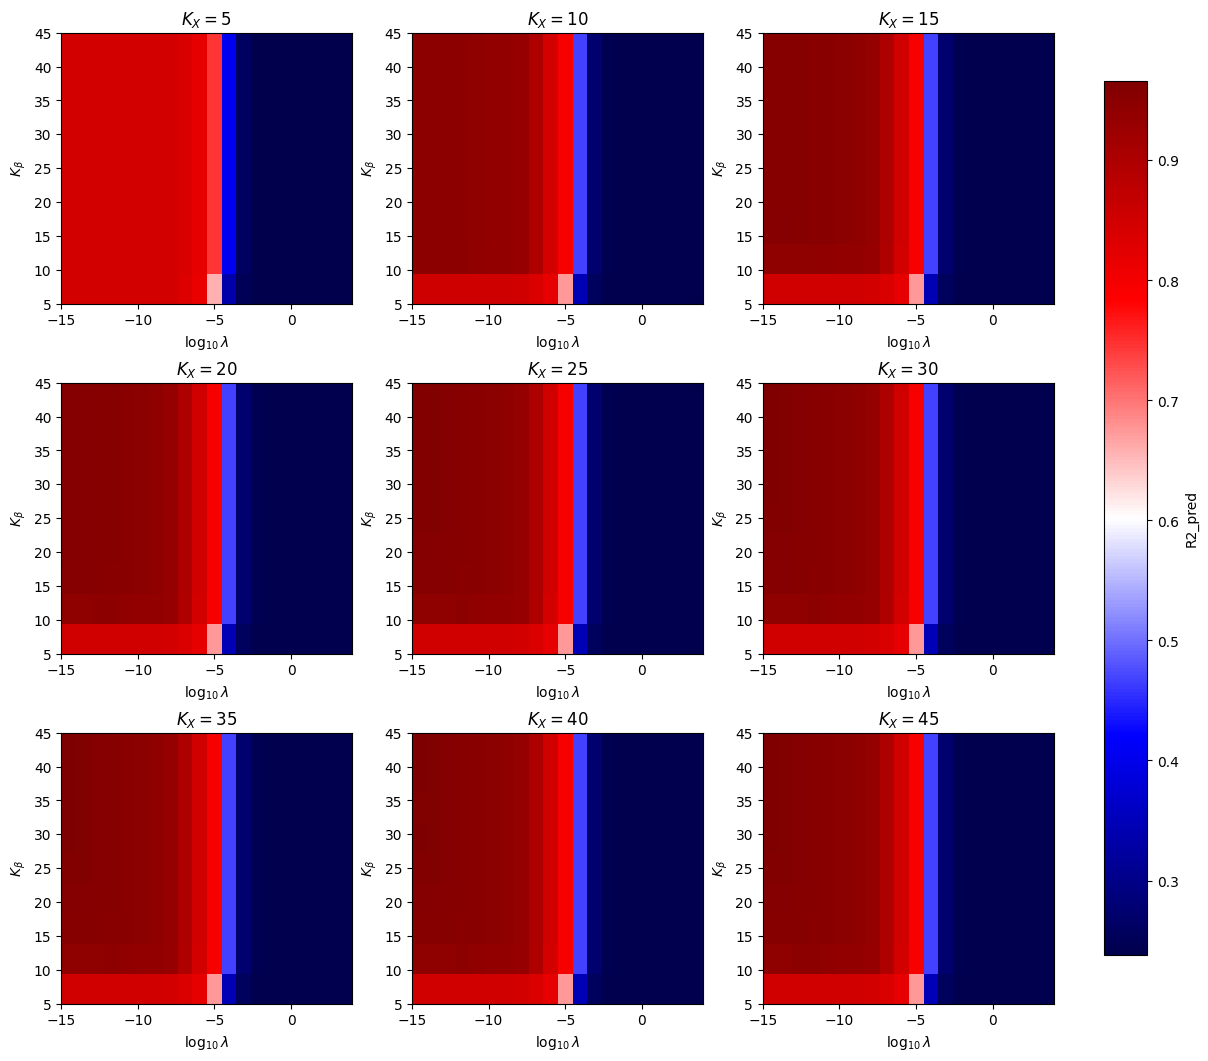

In [69]:
plot_small_multiples_heatmaps_from_df(tidy_df, value_col="R2_pred", cmap="seismic")

## For fixed $K_{X}$, plot how $\lambda$ affects $R_{pred}^{2}$ per $K_{\beta}$

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def plot_r2pred_vs_lambda_by_Kbeta(
    df,
    *,
    value_col="R2_pred",
    cmap="viridis",
    alpha=0.8,
    linewidth=1.5,
):
    """
    For each K_X, plot R2_pred vs log10(lambda),
    with one line per K_beta.
    """

    KX_values = sorted(df["K_X"].unique())
    Kbeta_values = sorted(df["K_beta"].unique())

    n_panels = len(KX_values)
    ncols = min(3, n_panels)
    nrows = int(np.ceil(n_panels / ncols))

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(4.5 * ncols, 3.5 * nrows),
        constrained_layout=True,
        sharex=True,
        sharey=True,
    )
    axes = np.atleast_1d(axes).ravel()

    # Colormap for K_beta lines
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(Kbeta_values)))

    for ax, KX in zip(axes, KX_values):
        sub_KX = df[df["K_X"] == KX]

        for color, Kb in zip(colors, Kbeta_values):
            sub = sub_KX[sub_KX["K_beta"] == Kb]

            if sub.empty:
                continue

            ax.plot(
                sub["log10_lam"],
                sub[value_col],
                marker="o",
                color=color,
                alpha=alpha,
                linewidth=linewidth,
                label=f"$K_\\beta={Kb}$",
            )

        ax.set_title(f"$K_X = {KX}$")
        ax.set_xlabel(r"$\log_{10}\lambda$")
        ax.set_ylabel(r"Predictive $R^2$")

    # Turn off unused axes
    for ax in axes[len(KX_values):]:
        ax.axis("off")

    # One shared legend (outside the grid)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="center right",
        bbox_to_anchor=(1.02, 0.5),
        title=r"$K_\beta$",
    )

    plt.show()


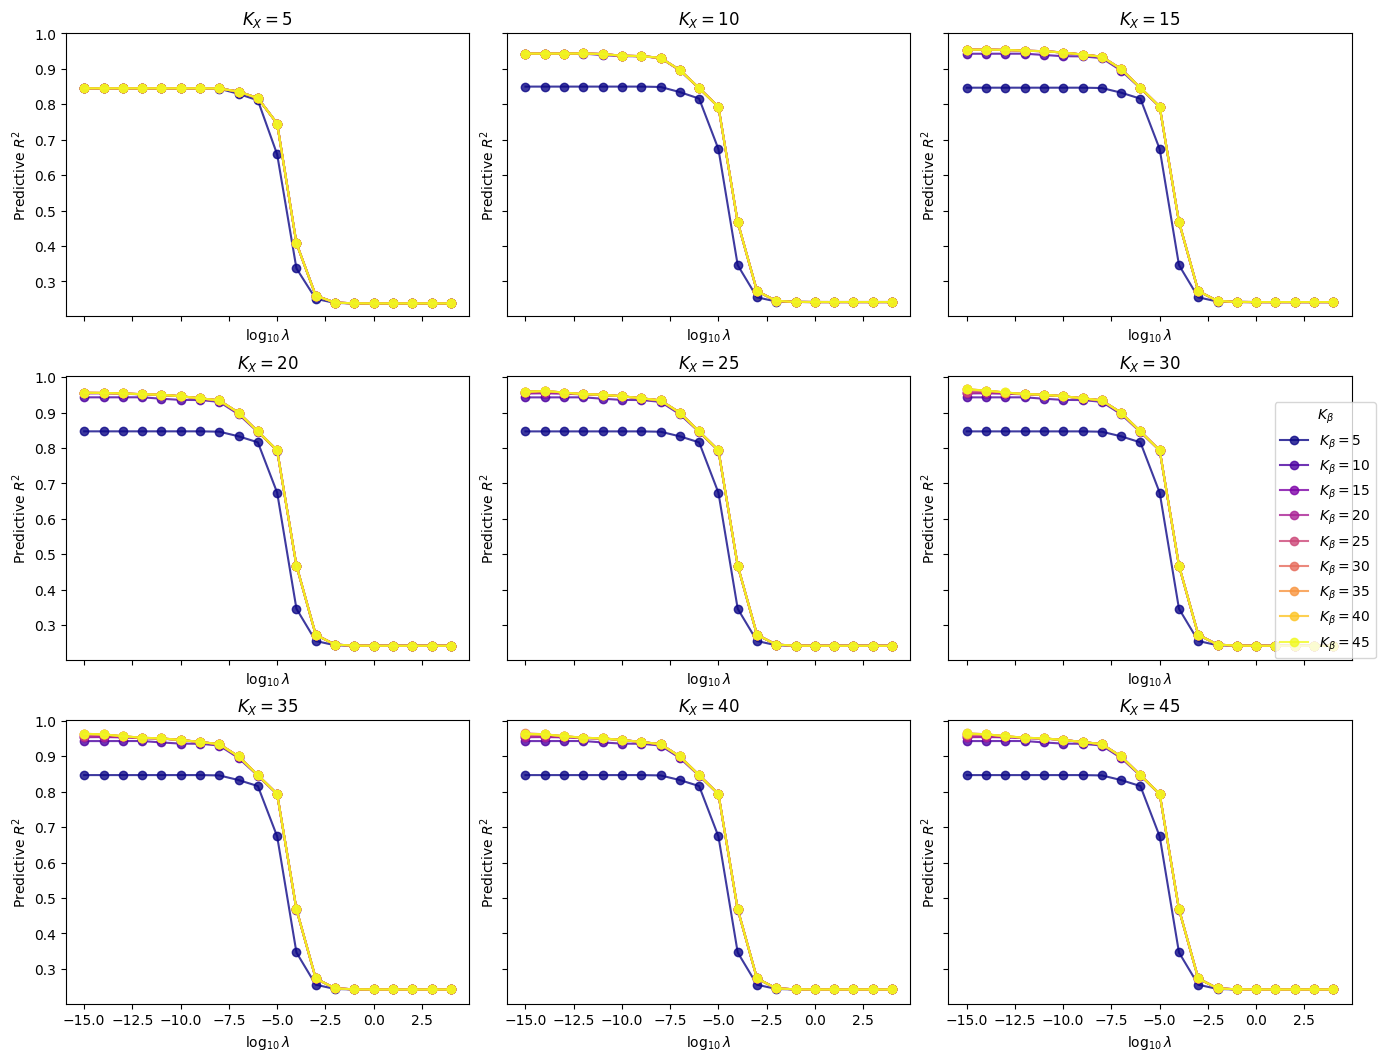

In [76]:
plot_r2pred_vs_lambda_by_Kbeta(
    tidy_df,
    value_col="R2_pred",
    cmap="plasma",   # try: "viridis", "plasma", "tab10"
)

## For each $(K_{X}, K_{\beta})$-pair, if we optimize $\lambda$ correctly, what is the maximum $R_{pred}^{2}$?

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def heatmap_max_r2pred(df, *, value_col="R2_pred", cmap="seismic"):
    """
    Heatmap of max over lambda of predictive R^2 for each (K_X, K_beta).
    Assumes df has columns: K_X, K_beta, value_col.
    """
    # 1) Reduce over lambda: max R2_pred for each (K_X, K_beta)
    df_best = (
        df.groupby(["K_X", "K_beta"], as_index=False)[value_col]
          .max()
          .rename(columns={value_col: f"max_{value_col}"})
    )

    # 2) Sort axes
    KX_values = sorted(df_best["K_X"].unique())
    Kbeta_values = sorted(df_best["K_beta"].unique())

    # 3) Pivot to matrix with rows=K_beta, cols=K_X
    M = (
        df_best.pivot(index="K_beta", columns="K_X", values=f"max_{value_col}")
              .reindex(index=Kbeta_values, columns=KX_values)
              .to_numpy()
    )

    # 4) Plot
    vmin = np.nanmin(M)
    vmax = np.nanmax(M)

    fig, ax = plt.subplots(figsize=(1.1 * len(KX_values) + 2, 0.5 * len(Kbeta_values) + 2))

    im = ax.imshow(
        M,
        origin="lower",
        aspect="auto",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        extent=[min(KX_values), max(KX_values), min(Kbeta_values), max(Kbeta_values)],
    )

    ax.set_xlabel(r"$K_X$")
    ax.set_ylabel(r"$K_\beta$")
    ax.set_title(rf"$\max_\lambda$ Predictive $R^2$ ({value_col})")

    ax.set_xticks(KX_values)
    ax.set_yticks(Kbeta_values)

    cbar = fig.colorbar(im, ax=ax, shrink=0.9)
    cbar.set_label(r"$\max_\lambda R^2_{\mathrm{pred}}$")

    plt.tight_layout()
    plt.show()

    return df_best  # handy to inspect / save


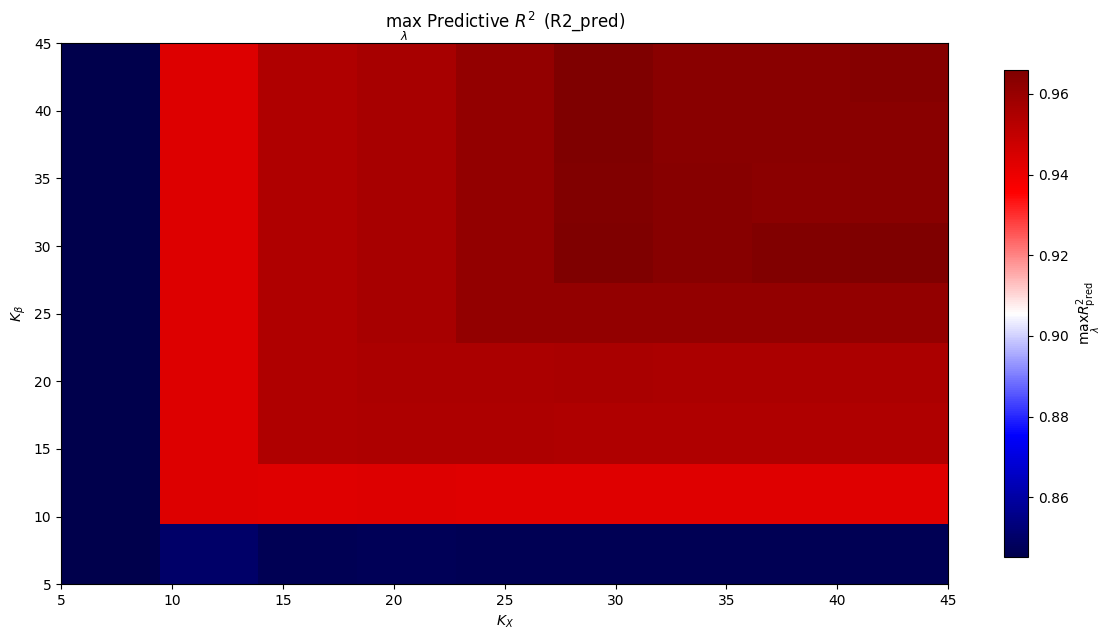

In [78]:
df_best = heatmap_max_r2pred(tidy_df, value_col="R2_pred", cmap="seismic")

In [79]:
def best_lambda_table(df, *, value_col="R2_pred"):
    # Row index of the max for each (K_X, K_beta)
    idx = df.groupby(["K_X", "K_beta"])[value_col].idxmax()
    return df.loc[idx].sort_values(["K_X", "K_beta"]).reset_index(drop=True)

best_df = best_lambda_table(tidy_df, value_col="R2_pred")
best_df.head()


,K_X,K_beta,lam,log10_lam,R2_pred,CV_score,df,R2,time_sec
0,5,5,1.000000e-09,-9.0,0.845133,5379.370263,5.976008,0.855417,0.000172
1,5,10,1.000000e-09,-9.0,0.845137,5379.244823,5.987794,0.855430,0.000144
2,5,15,1.000000e-09,-9.0,0.845137,5379.245004,5.987914,0.855430,0.000173
3,5,20,1.000000e-09,-9.0,0.845137,5379.245023,5.987925,0.855430,0.000180
4,5,25,1.000000e-09,-9.0,0.845137,5379.245027,5.987927,0.855430,0.000392


It seems that we're optimal as long as $K_{X} = 30$ and $30 \leq K_{\beta} \leq 45$!

## Predictive $R^{2}$ vs. df

In [80]:
import matplotlib.pyplot as plt
import numpy as np

def plot_r2pred_vs_df(
    df,
    *,
    color_by="K_X",
    alpha=0.6,
    s=35,
    cmap="viridis",
):
    """
    Scatter plot of predictive R^2 vs effective df,
    colored by K_X or K_beta.
    """

    fig, ax = plt.subplots(figsize=(6.5, 4.5))

    values = sorted(df[color_by].unique())
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(values)))

    for val, color in zip(values, colors):
        sub = df[df[color_by] == val]
        ax.scatter(
            sub["df"],
            sub["R2_pred"],
            s=s,
            alpha=alpha,
            color=color,
            label=f"{color_by}={val}",
        )

    ax.set_xlabel("Effective degrees of freedom")
    ax.set_ylabel(r"Predictive $R^2$")
    ax.set_title(r"Predictive $R^2$ vs effective degrees of freedom")

    ax.legend(title=color_by, bbox_to_anchor=(1.02, 1), loc="upper left")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


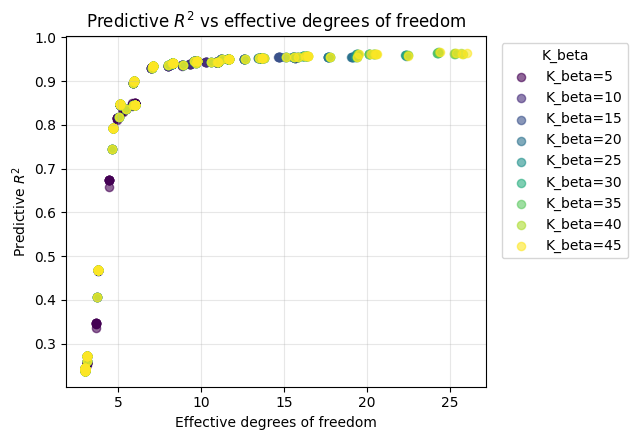

In [86]:
# plot_r2pred_vs_df(tidy_df, color_by="K_X")
# or
plot_r2pred_vs_df(tidy_df, color_by="K_beta")

In [82]:
import pandas as pd

def plot_binned_r2pred_vs_df(
    df,
    *,
    n_bins=20,
):
    """
    Bin df and plot mean ± SD of predictive R^2 in each bin.
    """

    df = df.copy()

    # Create df bins
    df["df_bin"] = pd.cut(df["df"], bins=n_bins)

    grouped = (
        df.groupby("df_bin", observed=True)["R2_pred"]
          .agg(["mean", "std", "count"])
          .reset_index()
    )

    # Bin centers for plotting
    bin_centers = grouped["df_bin"].apply(lambda x: x.mid)

    fig, ax = plt.subplots(figsize=(6.5, 4.5))

    ax.plot(bin_centers, grouped["mean"], marker="o", label="Mean")
    ax.fill_between(
        bin_centers,
        grouped["mean"] - grouped["std"],
        grouped["mean"] + grouped["std"],
        alpha=0.25,
        label="±1 SD",
    )

    ax.set_xlabel("Effective degrees of freedom")
    ax.set_ylabel(r"Predictive $R^2$")
    ax.set_title(r"Predictive $R^2$ vs df (binned)")
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()


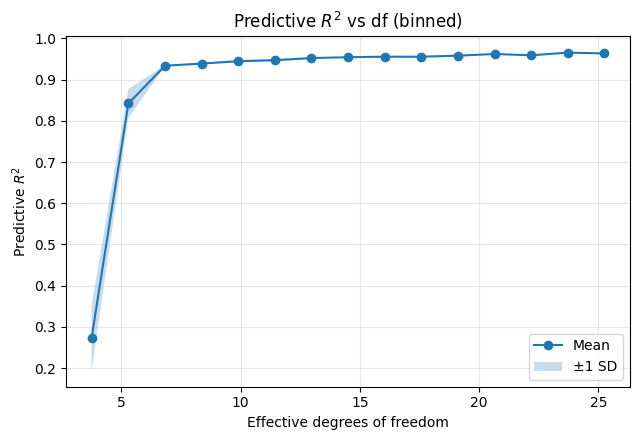

In [83]:
plot_binned_r2pred_vs_df(tidy_df, n_bins=15)

In [84]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_lowess_r2pred_vs_df(df, *, frac=0.25):
    x = df["df"].to_numpy()
    y = df["R2_pred"].to_numpy()

    smoothed = lowess(y, x, frac=frac, return_sorted=True)

    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    ax.scatter(x, y, alpha=0.3, s=20, label="Runs")
    ax.plot(smoothed[:, 0], smoothed[:, 1], color="black", linewidth=2, label="LOWESS")

    ax.set_xlabel("Effective degrees of freedom")
    ax.set_ylabel(r"Predictive $R^2$")
    ax.set_title(r"Predictive $R^2$ vs df (LOWESS)")
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()


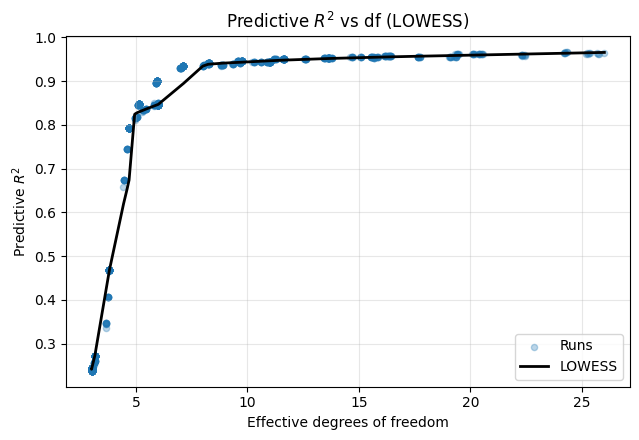

In [85]:
plot_lowess_r2pred_vs_df(tidy_df)

## Misc.

Create a directory to save these results to.

In [44]:
data_path = Path(os.getcwd()) / "data" / "03_flr"
data_path.mkdir(parents=True, exist_ok=True)

In [45]:
# # If we don't already have 10-repeated 10-fold CV results saved, generate them.
# results_path = data_path / "repeated_cv_results"
# if not os.path.isdir(results_path):
#     # Create this directory.
#     results_path.mkdir(parents=True, exist_ok=False)

#     alphas = np.logspace(-10, 10, 5)

#     # Inner CV: within each fold, standardize according to the train data, then perform CV for alpha on the train data.
#     pipe = make_pipeline(
#         StandardScaler(), RidgeCV(alphas=alphas, scoring="r2", cv=10)
#     )

#     # Outer CV: repeated 10 times, just like in the OLS script.
#     outer_cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)
#     scores = cross_val_score(
#         pipe, tecator_df.values, fat_df.values, cv=outer_cv, scoring="r2"
#     )

#     # Save all 100 scores.
#     with open(results_path / "results.pkl", "wb") as f:
#         pickle.dump(scores, f)
# else:
#     with open(results_path / "results.pkl", "rb") as f:
#         scores = pickle.load(f)

# ### Generate and save a CV boxplot comparison.

# plots_path = data_path / "plots"
# plots_path.mkdir(parents=True, exist_ok=True)

# with open(
#     str(
#         (
#             Path(__file__).parent.parent
#             / "data"
#             / "01_ols"
#             / "results"
#             / "ols_cv.pkl"
#         )
#     ),
#     "rb",
# ) as f:
#     ols_cv_scores = pickle.load(f).r2_scores

# plot_and_save_ols_ridge_cv_boxplots(
#     ols_scores=ols_cv_scores,
#     ridge_scores=scores,
#     filepath=plots_path / "comparison.png",
# )

NameError: name '__file__' is not defined